# NYC Parking Tickets & Tows vs Holidays (2019–2024)

This notebook uses **real NYC Open Data** + the NYPD **Tow Report (2020)** to explore:

1. Do parking tickets increase around major holidays (Thanksgiving, Christmas, July 4, etc.)?
2. Are there consistent patterns across multiple years?
3. Do city-tow counts show any similar patterns (for 2020)?
4. Can we *statistically* detect higher enforcement around holidays?

⚠️ **Important caveats**

- NYC law prohibits formal ticket quotas; pay/bonus structures are not public here.
- This notebook **cannot prove** officer/tow operator motivation or bonuses.
- What we *can* test: correlations between **time of year / holidays** and **ticket / tow volume**.

We’ll:

- Pull **daily ticket counts** for FY 2020–2024 from:
  - Parking Violations Issued – Fiscal Year 2020 (`p7t3-5i9s`)
  - FY 2021 (`kvfd-bves`)
  - FY 2022 (`7mxj-7a6y`)
  - FY 2023 (`869v-vr48`)
  - FY 2024 (`pvqr-7yc4`)
- Summarize counts **by calendar day**
- Build **holiday-centered plots** (A)
- Compute **z-scores & run a regression with a holiday-window dummy** (B)
- Load the NYPD **Tow Report – Removal of Vehicles Obstructing Traffic (2020)** Excel and look at monthly tow counts vs holidays (C)

All analysis here is **descriptive** and **exploratory**, not legal or HR evidence.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

BASE_URL_TEMPLATE = "https://data.cityofnewyork.us/resource/{dataset_id}.csv"

# Fiscal-year dataset IDs (NYC Open Data)
PARKING_DATASETS = {
    # Fiscal year label: (dataset_id, fiscal_start, fiscal_end)
    "FY2020": ("p7t3-5i9s", "2019-07-01", "2020-06-30"),
    "FY2021": ("kvfd-bves", "2020-07-01", "2021-06-30"),
    "FY2022": ("7mxj-7a6y", "2021-07-01", "2022-06-30"),
    "FY2023": ("869v-vr48", "2022-07-01", "2023-06-30"),
    "FY2024": ("pvqr-7yc4", "2023-07-01", "2024-06-30"),
}

# Tow Report Excel (2020 only – official NYPD Tow Report)
TOW_REPORT_2020_URL = (
    "https://www.nyc.gov/assets/nypd/downloads/excel/traffic_data/"
    "tow-report-removal-of-vehicles-obstructing-traffic-2020.xlsx"
)

# Reproducibility for sampling (if we ever need it)
RANDOM_STATE = 42


In [3]:
import urllib.parse

def fetch_daily_ticket_counts(dataset_id: str,
                              verbose: bool = True) -> pd.DataFrame:
    """
    Use NYC Open Data SoQL to get daily ticket counts from a Parking Violations dataset.
    NOTE: We don't filter by date here; each dataset already corresponds to one fiscal year.

    Returns:
        DataFrame with columns: ['date', 'tickets', 'dataset_id']
    """
    # IMPORTANT: no spaces in the query string!
    # We also skip aliasing ("as tickets") to avoid spaces and just rename in pandas.
    base_url = f"https://data.cityofnewyork.us/resource/{dataset_id}.csv"
    url = (
        base_url
        + "?$select=issue_date,count(*)&$group=issue_date&$order=issue_date&$limit=50000"
    )

    if verbose:
        print(f"Fetching daily counts for {dataset_id} (entire fiscal year)")

    df = pd.read_csv(url)

    # Socrata will return columns: 'issue_date' and 'count'
    df["date"] = pd.to_datetime(df["issue_date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    # Rename count -> tickets
    if "count" in df.columns:
        df = df.rename(columns={"count": "tickets"})
    else:
        # Just in case the aggregation column is named differently
        # (sometimes 'count_1' or similar)
        count_cols = [c for c in df.columns if c.startswith("count")]
        if count_cols:
            df = df.rename(columns={count_cols[0]: "tickets"})
        else:
            raise ValueError(f"Could not find count column in {df.columns.tolist()}")

    df["tickets"] = df["tickets"].astype(int)
    df["dataset_id"] = dataset_id

    return df[["date", "tickets", "dataset_id"]]


In [4]:
all_daily = []

for fy, (dataset_id, start, end) in PARKING_DATASETS.items():
    df_fy = fetch_daily_ticket_counts(dataset_id)
    df_fy["fiscal_year"] = fy
    all_daily.append(df_fy)

tickets_daily = pd.concat(all_daily, ignore_index=True).sort_values("date")
tickets_daily.head(), tickets_daily.tail(), tickets_daily["fiscal_year"].value_counts()


Fetching daily counts for p7t3-5i9s (entire fiscal year)
Fetching daily counts for kvfd-bves (entire fiscal year)
Fetching daily counts for 7mxj-7a6y (entire fiscal year)
Fetching daily counts for 869v-vr48 (entire fiscal year)
Fetching daily counts for pvqr-7yc4 (entire fiscal year)


(           date  tickets dataset_id fiscal_year
 1475 1971-05-20        1  kvfd-bves      FY2021
 5911 1971-09-06        1  pvqr-7yc4      FY2024
 1476 1971-11-06        1  kvfd-bves      FY2021
 4167 1972-04-04        1  869v-vr48      FY2023
 0    1972-05-08        1  p7t3-5i9s      FY2020,
            date  tickets dataset_id fiscal_year
 1474 2064-06-04        1  p7t3-5i9s      FY2020
 4164 2065-05-24        1  7mxj-7a6y      FY2022
 5910 2066-06-24        1  869v-vr48      FY2023
 4165 2067-04-21        1  7mxj-7a6y      FY2022
 4166 2067-11-28        1  7mxj-7a6y      FY2022,
 fiscal_year
 FY2024    2338
 FY2023    1744
 FY2020    1475
 FY2021    1387
 FY2022    1305
 Name: count, dtype: int64)

In [5]:
tickets_daily["date"] = pd.to_datetime(tickets_daily["date"])
tickets_daily = tickets_daily.set_index("date").sort_index()

# Derive features
tickets_daily["year"] = tickets_daily.index.year
tickets_daily["month"] = tickets_daily.index.month
tickets_daily["day"] = tickets_daily.index.day
tickets_daily["weekday"] = tickets_daily.index.day_name()

# Clean calendar range (should already be this, but just to be explicit)
tickets_daily = tickets_daily.loc["2019-07-01":"2024-06-30"].copy()

print(tickets_daily.shape)
tickets_daily.head()


(4693, 7)


,tickets,dataset_id,fiscal_year,year,month,day,weekday
date,,,,,,,
2019-07-01,1,kvfd-bves,FY2021,2019,7,1,Monday
2019-07-01,33594,p7t3-5i9s,FY2020,2019,7,1,Monday
2019-07-02,39124,p7t3-5i9s,FY2020,2019,7,2,Tuesday
2019-07-03,36723,p7t3-5i9s,FY2020,2019,7,3,Wednesday
2019-07-04,5894,p7t3-5i9s,FY2020,2019,7,4,Thursday


In [33]:
# We'll create a small manual holiday calendar (only dates in our 2019–2024 range)
# You can expand if you want more holidays.
HOLIDAYS = {
    "NewYear": [
        "2020-01-01", "2021-01-01", "2022-01-01", "2023-01-01", "2024-01-01",
    ],
    "MemorialDay": [
        "2020-05-25", "2021-05-31", "2022-05-30", "2023-05-29", "2024-05-27",
    ],
    "July4": [
        "2020-07-04", "2021-07-04", "2022-07-04", "2023-07-04", "2024-07-04",
    ],
    "LaborDay": [
        "2019-09-02", "2020-09-07", "2021-09-06", "2022-09-05", "2023-09-04",
    ],
    "Thanksgiving": [
        "2019-11-28", "2020-11-26", "2021-11-25", "2022-11-24", "2023-11-23",
    ],
    "Christmas": [
        "2019-12-25", "2020-12-25", "2021-12-25", "2022-12-25", "2023-12-25",
    ],
}

HOLIDAYS = {k: [pd.to_datetime(d).date() for d in v] for k, v in HOLIDAYS.items()}


def nearest_holiday_distance(date: pd.Timestamp) -> int:
    """
    Return distance in days from this date to the nearest defined holiday (any type).
    """
    d = date.date()
    distances = []
    for holiday_list in HOLIDAYS.values():
        for h in holiday_list:
            distances.append((d - h).days)
    if not distances:
        return np.nan
    # Absolute distance to nearest
    return int(min(distances, key=lambda x: abs(x)))


def is_in_holiday_window(date: pd.Timestamp, window_days: int = 7) -> bool:
    """
    True if this date is within +/- window_days of any holiday.
    """
    d = date.date()
    for holiday_list in HOLIDAYS.values():
        for h in holiday_list:
            if abs((d - h).days) <= window_days:
                return True
    return False


In [34]:
tickets_daily["days_to_any_holiday"] = tickets_daily.index.map(nearest_holiday_distance)
tickets_daily["is_holiday_window_7d"] = tickets_daily.index.map(
    lambda d: is_in_holiday_window(d, window_days=7)
)
tickets_daily["is_holiday_window_14d"] = tickets_daily.index.map(
    lambda d: is_in_holiday_window(d, window_days=14)
)

tickets_daily.head(15)


,tickets,dataset_id,fiscal_year,year,month,day,weekday,days_to_any_holiday,is_holiday_window_7d,is_holiday_window_14d
date,,,,,,,,,,
2019-07-01,1,kvfd-bves,FY2021,2019,7,1,Monday,-63,False,False
2019-07-01,33594,p7t3-5i9s,FY2020,2019,7,1,Monday,-63,False,False
2019-07-02,39124,p7t3-5i9s,FY2020,2019,7,2,Tuesday,-62,False,False
2019-07-03,36723,p7t3-5i9s,FY2020,2019,7,3,Wednesday,-61,False,False
2019-07-04,5894,p7t3-5i9s,FY2020,2019,7,4,Thursday,-60,False,False
2019-07-05,1,7mxj-7a6y,FY2022,2019,7,5,Friday,-59,False,False
2019-07-05,36169,p7t3-5i9s,FY2020,2019,7,5,Friday,-59,False,False
2019-07-06,19094,p7t3-5i9s,FY2020,2019,7,6,Saturday,-58,False,False
2019-07-07,7394,p7t3-5i9s,FY2020,2019,7,7,Sunday,-57,False,False


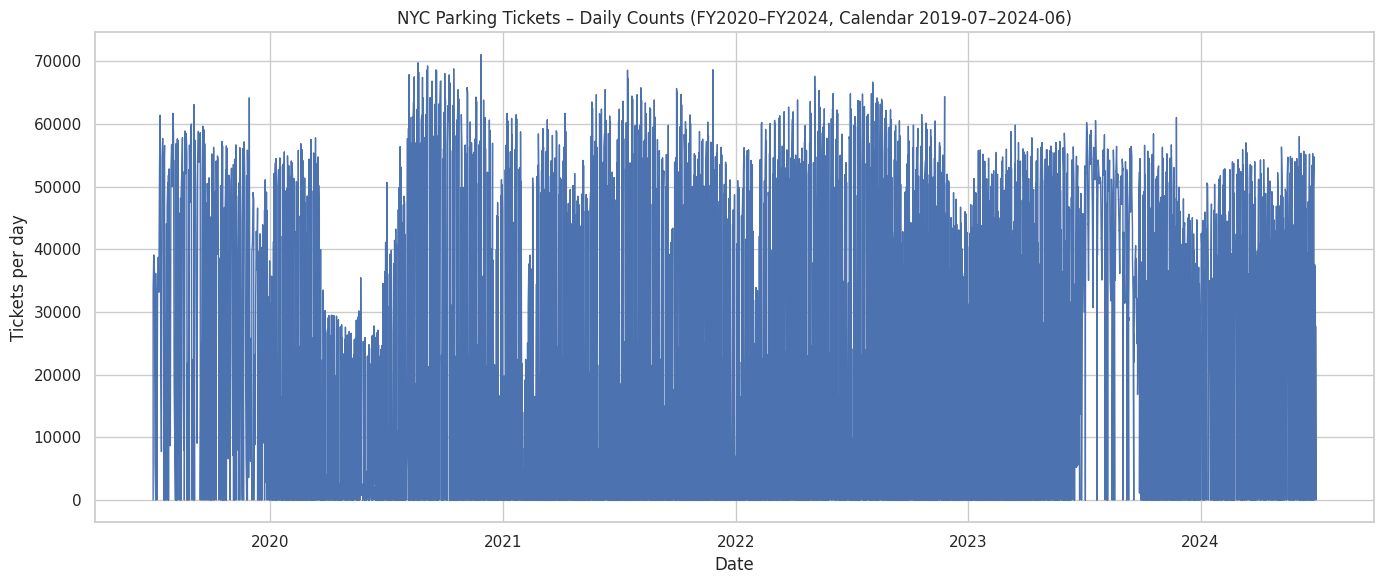

In [35]:
plt.figure(figsize=(14, 6))
plt.plot(tickets_daily.index, tickets_daily["tickets"], linewidth=1)
plt.title("NYC Parking Tickets – Daily Counts (FY2020–FY2024, Calendar 2019-07–2024-06)")
plt.xlabel("Date")
plt.ylabel("Tickets per day")
plt.tight_layout()
plt.show()


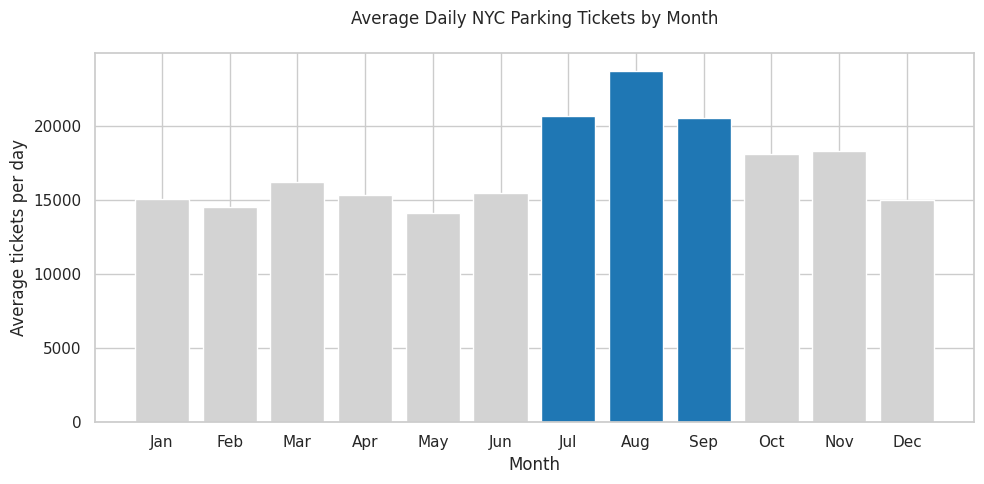

,month_num,tickets,month_name
0,1,15054.476543,Jan
1,2,14532.585752,Feb
2,3,16211.590799,Mar
3,4,15366.592105,Apr
4,5,14140.741860,May
5,6,15470.733491,Jun
6,7,20651.852713,Jul
7,8,23727.570667,Aug
8,9,20518.252011,Sep
9,10,18125.200000,Oct


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Make sure date is the index / datetime ---
if "date" in tickets_daily.columns:
    tickets_daily["date"] = pd.to_datetime(tickets_daily["date"])
    tickets_daily = tickets_daily.set_index("date").sort_index()

# --- 2. Add month number & month name ---
tickets_daily["month_num"] = tickets_daily.index.month
tickets_daily["month_name"] = tickets_daily.index.month_name()

# --- 3. Compute avg tickets per day by calendar month across all years ---
monthly_avg = (
    tickets_daily
    .groupby("month_num")["tickets"]
    .mean()
    .reset_index()
)

# Attach ordered month names for pretty axis labels
month_order = [1,2,3,4,5,6,7,8,9,10,11,12]
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
monthly_avg["month_name"] = monthly_avg["month_num"].map(dict(zip(month_order, month_names)))

# Sort by calendar order just in case
monthly_avg = monthly_avg.sort_values("month_num")

# --- 4. Build a color list to highlight top 3
colors = []
for m in monthly_avg["month_num"]:
    if m in [7, 8, 9]:   # February, October, November
        colors.append("tab:blue")   # highlight
    else:
        colors.append("lightgray")  # background

# --- 5. Plot ---
plt.figure(figsize=(10,5))
plt.bar(monthly_avg["month_name"], monthly_avg["tickets"], color=colors)
plt.title("Average Daily NYC Parking Tickets by Month\n")
plt.xlabel("Month")
plt.ylabel("Average tickets per day")
plt.tight_layout()
plt.show()

monthly_avg


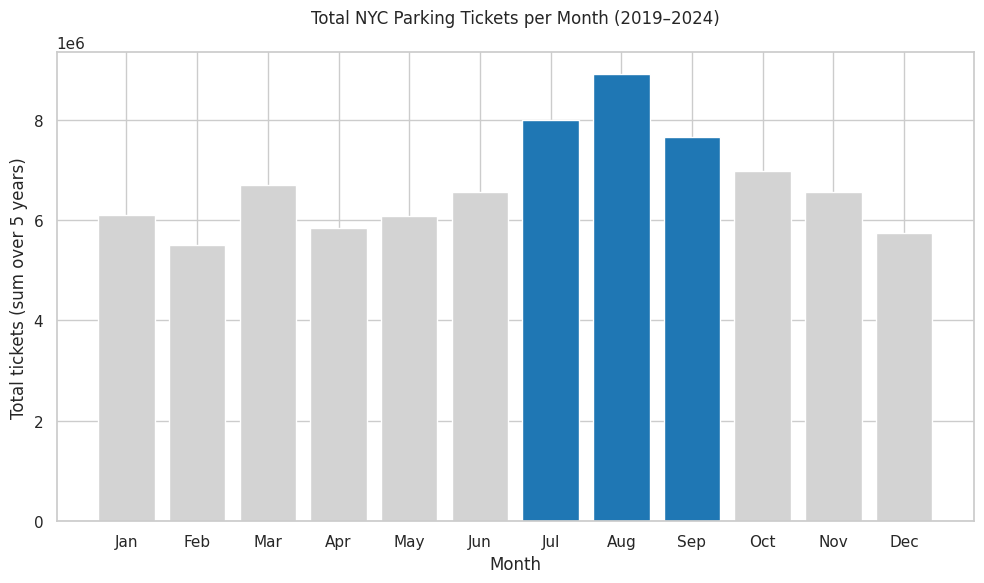

,month_num,tickets,month_name
0,1,6097063,Jan
1,2,5507850,Feb
2,3,6695387,Mar
3,4,5839305,Apr
4,5,6080519,May
5,6,6559591,Jun
6,7,7992267,Jul
7,8,8897839,Aug
8,9,7653308,Sep
9,10,6978202,Oct


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Ensure datetime index (if not already)
# ----------------------------------------------------
if "date" in tickets_daily.columns:
    tickets_daily["date"] = pd.to_datetime(tickets_daily["date"])
    tickets_daily = tickets_daily.set_index("date").sort_index()

# ----------------------------------------------------
# 2. Add month features
# ----------------------------------------------------
tickets_daily["month_num"] = tickets_daily.index.month
tickets_daily["month_name"] = tickets_daily.index.month_name()

# ----------------------------------------------------
# 3. Compute *total* ticket counts per calendar month
# ----------------------------------------------------
monthly_total = (
    tickets_daily
    .groupby("month_num")["tickets"]
    .sum()
    .reset_index()
)

# Add ordered month names
month_order = [1,2,3,4,5,6,7,8,9,10,11,12]
month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]

monthly_total["month_name"] = monthly_total["month_num"].map(
    dict(zip(month_order, month_labels))
)

monthly_total = monthly_total.sort_values("month_num")

# ----------------------------------------------------
# 4. Highlight spike months
# ----------------------------------------------------
spike_months = [7, 8, 9]   # Your 3 peak months
colors = [
    "tab:blue" if m in spike_months else "lightgray"
    for m in monthly_total["month_num"]
]

# ----------------------------------------------------
# 5. Plot bar chart
# ----------------------------------------------------
plt.figure(figsize=(10,6))
plt.bar(monthly_total["month_name"], monthly_total["tickets"], color=colors)
plt.title("Total NYC Parking Tickets per Month (2019–2024)\n")
plt.xlabel("Month")
plt.ylabel("Total tickets (sum over 5 years)")
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 6. Print the table for reference
# ----------------------------------------------------
monthly_total



Holiday: Thanksgiving


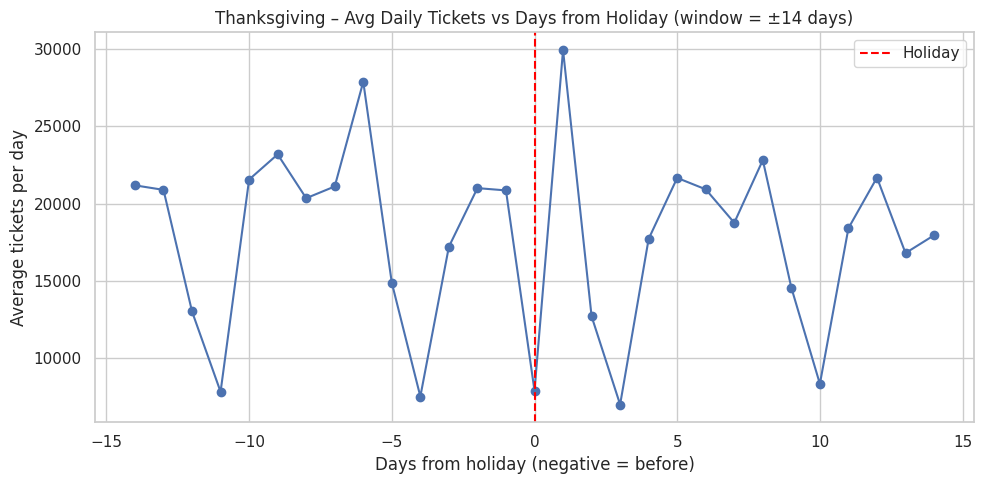

,offset,mean,count
0,-14,21181.692308,13
1,-13,20889.090909,11
2,-12,13004.416667,12
3,-11,7799.333333,12
4,-10,21559.333333,12
5,-9,23190.583333,12
6,-8,20349.076923,13
7,-7,21109.928571,14
8,-6,27895.800000,10
9,-5,14865.181818,11



Holiday: Christmas


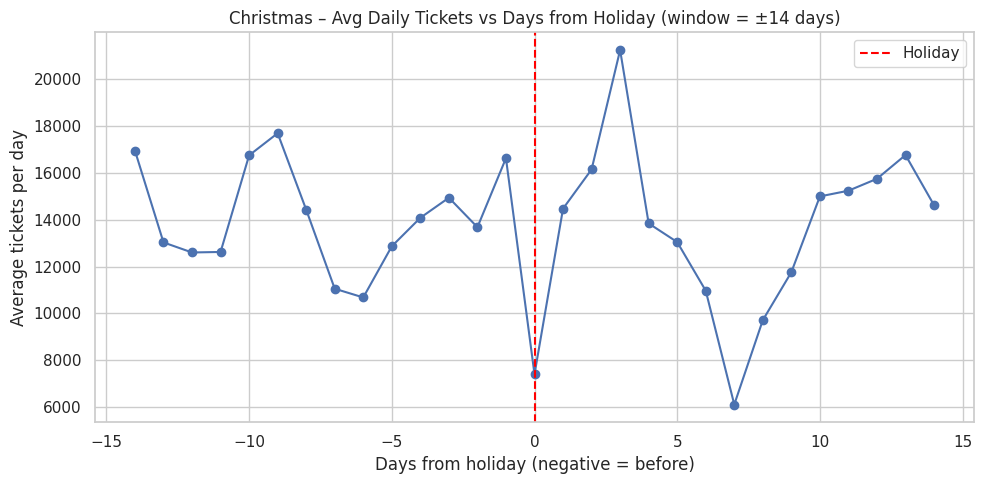

,offset,mean,count
0,-14,16943.090909,11
1,-13,13029.769231,13
2,-12,12601.133333,15
3,-11,12623.062500,16
4,-10,16743.666667,12
5,-9,17686.750000,12
6,-8,14425.636364,11
7,-7,11055.384615,13
8,-6,10682.571429,14
9,-5,12865.428571,14



Holiday: July4


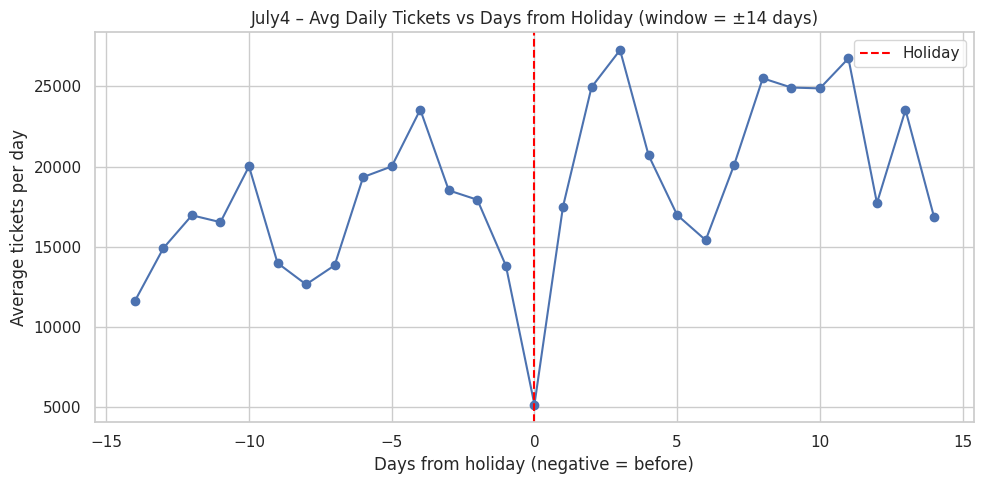

,offset,mean,count
0,-14,11614.533333,15
1,-13,14916.533333,15
2,-12,16966.071429,14
3,-11,16537.800000,15
4,-10,20018.538462,13
5,-9,13988.312500,16
6,-8,12653.357143,14
7,-7,13845.769231,13
8,-6,19351.083333,12
9,-5,20013.923077,13



Holiday: NewYear


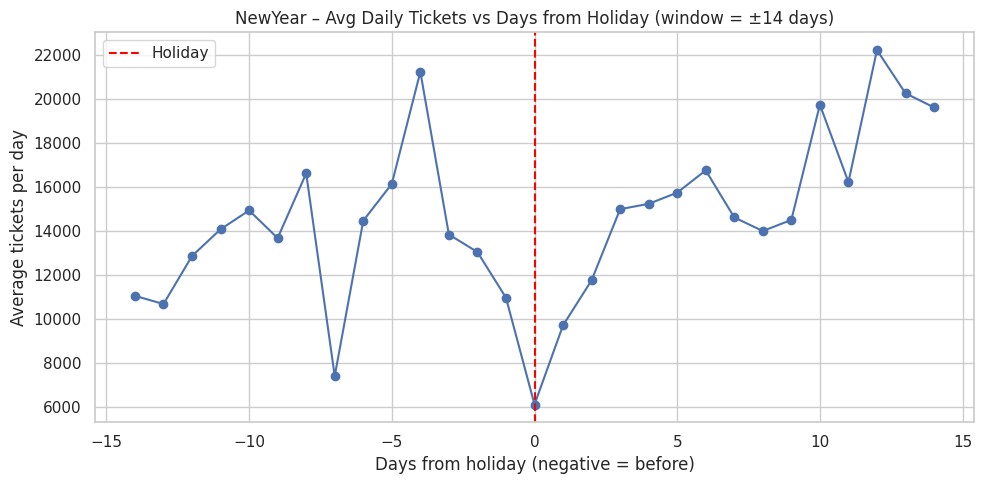

,offset,mean,count
0,-14,11055.384615,13
1,-13,10682.571429,14
2,-12,12865.428571,14
3,-11,14079.785714,14
4,-10,14935.750000,12
5,-9,13678.812500,16
6,-8,16621.500000,10
7,-7,7407.777778,9
8,-6,14470.100000,10
9,-5,16142.636364,11


In [36]:
def holiday_centered_curve(holiday_name: str, window: int = 14) -> pd.DataFrame:
    """
    Build a dataframe with columns:
      - offset (days from holiday, negative=before, positive=after)
      - tickets (daily tickets)
      - holiday_date
    for all years where this holiday appears in HOLIDAYS.
    """
    rows = []
    holiday_dates = HOLIDAYS[holiday_name]

    for hdate in holiday_dates:
        h = pd.to_datetime(hdate)
        start = h - pd.Timedelta(days=window)
        end = h + pd.Timedelta(days=window)

        df_window = tickets_daily.loc[start:end].copy()
        if df_window.empty:
            continue

        df_window["offset"] = (df_window.index.date - hdate).astype("timedelta64[D]").astype(int)
        df_window["holiday_date"] = hdate
        rows.append(df_window[["tickets", "offset", "holiday_date"]])

    if not rows:
        return pd.DataFrame(columns=["tickets", "offset", "holiday_date"])

    return pd.concat(rows, ignore_index=True)


def plot_holiday_curve(holiday_name: str, window: int = 14):
    df_h = holiday_centered_curve(holiday_name, window)
    if df_h.empty:
        print(f"No data for holiday {holiday_name}")
        return

    # Average across years by offset
    curve = df_h.groupby("offset")["tickets"].agg(["mean", "count"]).reset_index()

    plt.figure(figsize=(10, 5))
    plt.plot(curve["offset"], curve["mean"], marker="o")
    plt.axvline(0, color="red", linestyle="--", label="Holiday")
    plt.title(f"{holiday_name} – Avg Daily Tickets vs Days from Holiday (window = ±{window} days)")
    plt.xlabel("Days from holiday (negative = before)")
    plt.ylabel("Average tickets per day")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    display(curve)


for holiday in ["Thanksgiving", "Christmas", "July4", "NewYear"]:
    print("\n==============================")
    print(f"Holiday: {holiday}")
    plot_holiday_curve(holiday, window=14)


In [37]:
# Baseline: days outside ±14 days of any holiday
baseline = tickets_daily[~tickets_daily["is_holiday_window_14d"]]["tickets"]

mu = baseline.mean()
sigma = baseline.std()

tickets_daily["z_score"] = (tickets_daily["tickets"] - mu) / sigma

print("Baseline mean:", mu)
print("Baseline std:", sigma)

tickets_daily[["tickets", "z_score", "is_holiday_window_14d"]].head()


Baseline mean: 17043.46533238027
Baseline std: 23159.887225615646


,tickets,z_score,is_holiday_window_14d
date,,,
2019-07-01,1,-0.735861,False
2019-07-01,33594,0.714621,False
2019-07-02,39124,0.953396,False
2019-07-03,36723,0.849725,False
2019-07-04,5894,-0.481413,False


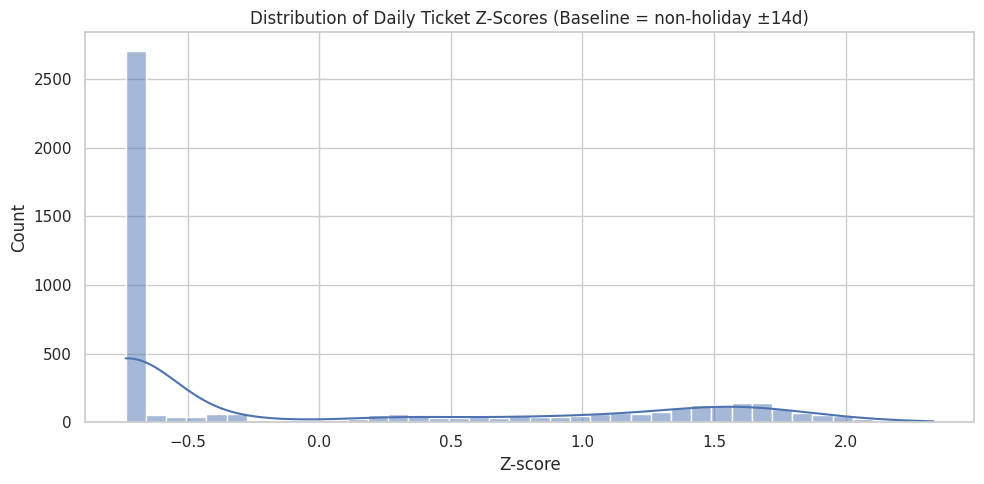

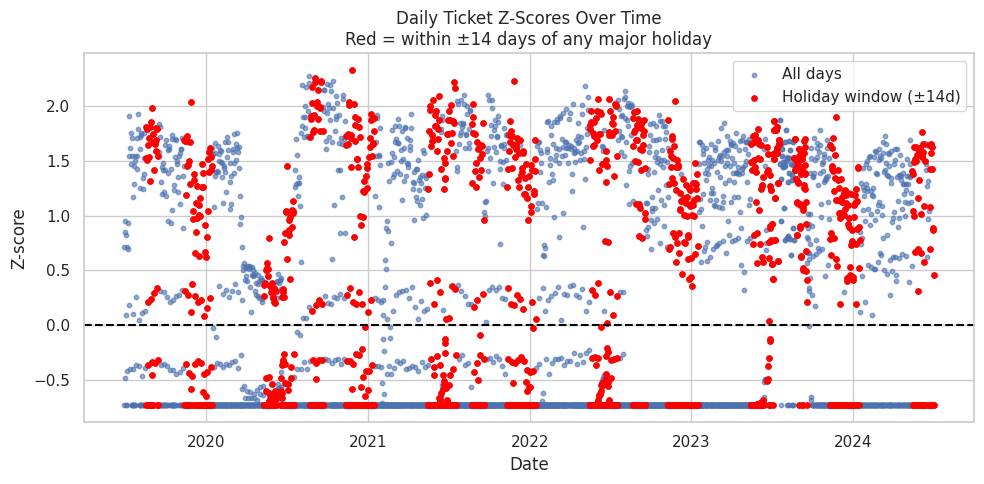

In [38]:
plt.figure(figsize=(10, 5))
sns.histplot(tickets_daily["z_score"], bins=40, kde=True)
plt.title("Distribution of Daily Ticket Z-Scores (Baseline = non-holiday ±14d)")
plt.xlabel("Z-score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(
    tickets_daily.index,
    tickets_daily["z_score"],
    s=10,
    alpha=0.6,
    label="All days",
)
plt.scatter(
    tickets_daily.index[tickets_daily["is_holiday_window_14d"]],
    tickets_daily.loc[tickets_daily["is_holiday_window_14d"], "z_score"],
    s=15,
    color="red",
    label="Holiday window (±14d)",
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Daily Ticket Z-Scores Over Time\nRed = within ±14 days of any major holiday")
plt.ylabel("Z-score")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# Create categorical features
df_reg = tickets_daily.copy()
df_reg["month_str"] = df_reg["month"].astype(str)
df_reg["weekday_str"] = df_reg["weekday"].astype(str)

# We'll use 14-day holiday window
df_reg["holiday_window_14"] = df_reg["is_holiday_window_14d"].astype(int)

# Use statsmodels formula API
formula = "tickets ~ holiday_window_14 + C(month_str) + C(weekday_str)"

model = smf.ols(formula=formula, data=df_reg).fit(cov_type="HC3")  # robust SE
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                tickets   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     24.93
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           7.35e-80
Time:                        22:34:29   Log-Likelihood:                -53671.
No. Observations:                4693   AIC:                         1.074e+05
Df Residuals:                    4674   BIC:                         1.075e+05
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Holiday window (±14 days) coefficient:
  Estimate: 702.667365126062
  95% CI : (-1059.282552561824, 2464.617282813948)


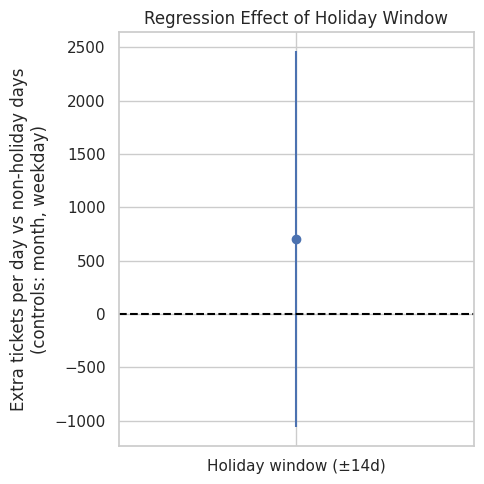

In [40]:
coef = model.params["holiday_window_14"]
conf_int = model.conf_int().loc["holiday_window_14"]

print("Holiday window (±14 days) coefficient:")
print("  Estimate:", coef)
print("  95% CI :", tuple(conf_int))

plt.figure(figsize=(5, 5))
plt.errorbar(
    x=[0],
    y=[coef],
    yerr=[[coef - conf_int[0]], [conf_int[1] - coef]],
    fmt="o",
)
plt.axhline(0, color="black", linestyle="--")
plt.xticks([0], ["Holiday window (±14d)"])
plt.ylabel("Extra tickets per day vs non-holiday days\n(controls: month, weekday)")
plt.title("Regression Effect of Holiday Window")
plt.tight_layout()
plt.show()


In [51]:
try:
    tow_raw = pd.read_excel(TOW_REPORT_2020_URL)
    print("Loaded tow report shape:", tow_raw.shape)
    display(tow_raw.head())
except Exception as e:
    print("Error loading tow report Excel:", e)
    print("If this fails, open the URL in your browser to confirm it works,")
    print("then download + upload the file to Colab and change the path.")


Loaded tow report shape: (82, 13)


,"NYC Administrative Code 14-184 requires that the NYPD furnish a report of the number of vehicles towed by the Department in 2020 that were obstructing a sidewalk, crosswalk, fire hydrant, bicycle lane, or bus lane; disaggregated by the police precinct in which such vehicles were located and by the month in which such vehicles were towed.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Total # of Department Tows (for obstructing a ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Precinct,January,February,March,April,May,June,July,August,September,October,November,December
2,1,30,44,53,44,63,21,28,36,34,40,44,20
3,5,5,1,8,7,2,2,4,2,0,2,2,2
4,6,61,52,69,32,60,35,53,61,56,81,47,49


In [13]:
TOW_REPORT_2020_URL = (
    "https://www.nyc.gov/assets/nypd/downloads/excel/traffic_data/"
    "tow-report-removal-of-vehicles-obstructing-traffic-2020.xlsx"
)

# Row index 2 (0-based) is: Precinct, January, February, ..., December
tow_data = pd.read_excel(TOW_REPORT_2020_URL, header=2)

print("tow_data shape:", tow_data.shape)
print("Columns:", tow_data.columns.tolist())
tow_data.head()


tow_data shape: (80, 13)
Columns: ['Precinct', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


,Precinct,January,February,March,April,May,June,July,August,September,October,November,December
0,1,30.0,44.0,53.0,44.0,63.0,21.0,28.0,36.0,34.0,40.0,44.0,20.0
1,5,5.0,1.0,8.0,7.0,2.0,2.0,4.0,2.0,0.0,2.0,2.0,2.0
2,6,61.0,52.0,69.0,32.0,60.0,35.0,53.0,61.0,56.0,81.0,47.0,49.0
3,7,6.0,9.0,22.0,33.0,9.0,17.0,7.0,7.0,5.0,9.0,7.0,11.0
4,9,31.0,30.0,52.0,20.0,35.0,13.0,22.0,24.0,31.0,29.0,36.0,27.0


In [14]:
tow_data.columns.tolist()
tow_data.head()

,Precinct,January,February,March,April,May,June,July,August,September,October,November,December
0,1,30.0,44.0,53.0,44.0,63.0,21.0,28.0,36.0,34.0,40.0,44.0,20.0
1,5,5.0,1.0,8.0,7.0,2.0,2.0,4.0,2.0,0.0,2.0,2.0,2.0
2,6,61.0,52.0,69.0,32.0,60.0,35.0,53.0,61.0,56.0,81.0,47.0,49.0
3,7,6.0,9.0,22.0,33.0,9.0,17.0,7.0,7.0,5.0,9.0,7.0,11.0
4,9,31.0,30.0,52.0,20.0,35.0,13.0,22.0,24.0,31.0,29.0,36.0,27.0


In [15]:
# Month names we expect
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Detect month columns exactly by name
month_cols = [c for c in tow_data.columns if str(c).strip() in month_names]
print("Detected month columns:", month_cols)

if not month_cols:
    raise ValueError("Could not detect any month columns – check tow_data.columns")

# Sum across precincts (rows) for each month (columns)
tow_agg = (
    tow_data[month_cols]
    .astype(float)  # in case they come in as strings
    .sum(axis=0)
    .reset_index()
    .rename(columns={"index": "month_label", 0: "tows"})
)

display(tow_agg)


Detected month columns: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


,month_label,tows
0,January,2884.0
1,February,3054.0
2,March,2902.0
3,April,2026.0
4,May,2164.0
5,June,1698.0
6,July,2032.0
7,August,2820.0
8,September,2876.0
9,October,3288.0


,month_label,tows,month_num
0,January,2884.0,1
1,February,3054.0,2
2,March,2902.0,3
3,April,2026.0,4
4,May,2164.0,5
5,June,1698.0,6
6,July,2032.0,7
7,August,2820.0,8
8,September,2876.0,9
9,October,3288.0,10


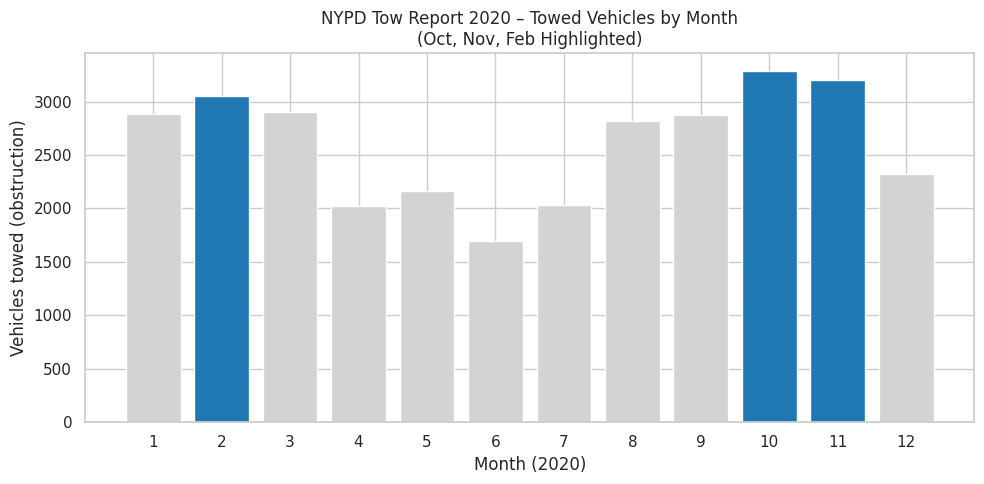

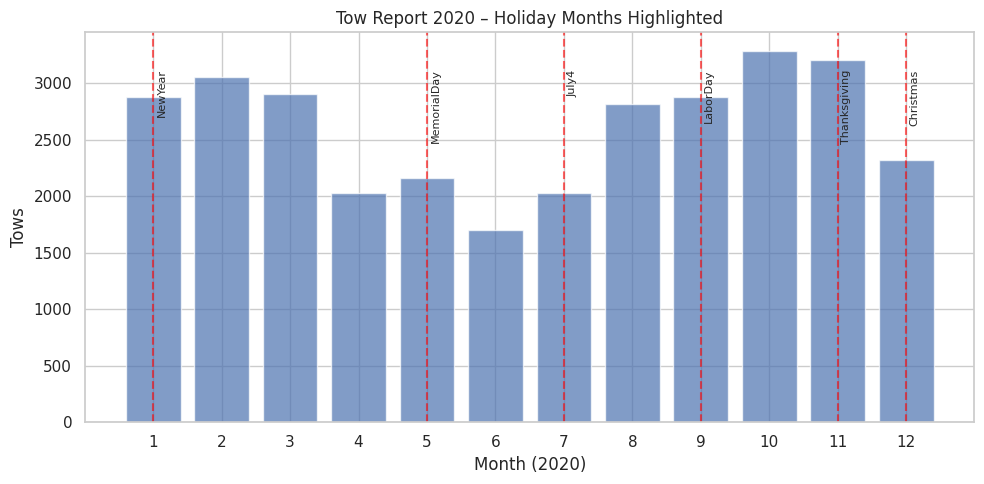

In [18]:
if "tow_agg" in locals():

    def parse_month_label(val):
        if pd.isna(val):
            return np.nan
        s = str(val).strip()
        # try integer
        try:
            m = int(s)
            if 1 <= m <= 12:
                return m
        except ValueError:
            pass
        # try full month name
        try:
            dt = pd.to_datetime(s, format="%B")
            return dt.month
        except Exception:
            pass
        # try abbreviated month name
        try:
            dt = pd.to_datetime(s, format="%b")
            return dt.month
        except Exception:
            return np.nan

    tow_agg["month_num"] = tow_agg["month_label"].apply(parse_month_label)
    tow_agg = tow_agg.dropna(subset=["month_num"])
    tow_agg["month_num"] = tow_agg["month_num"].astype(int)

    tow_agg = tow_agg.sort_values("month_num")
    display(tow_agg)

    # =========================================================
    #  HIGHLIGHT these months: February (2), October (10), November (11)
    # =========================================================
    spike_months = [2, 10, 11]

    colors = [
        "tab:blue" if m in spike_months else "lightgray"
        for m in tow_agg["month_num"]
    ]

    # First graph with highlight colors
    plt.figure(figsize=(10, 5))
    plt.bar(tow_agg["month_num"], tow_agg["tows"], color=colors)
    plt.xticks(tow_agg["month_num"])
    plt.xlabel("Month (2020)")
    plt.ylabel("Vehicles towed (obstruction)")
    plt.title("NYPD Tow Report 2020 – Towed Vehicles by Month\n(Oct, Nov, Feb Highlighted)")
    plt.tight_layout()
    plt.show()

    # =========================================================
    # Second chart (holiday markers) stays unchanged
    # =========================================================
    holiday_months_2020 = {
        "NewYear": 1,
        "MemorialDay": 5,
        "July4": 7,
        "LaborDay": 9,
        "Thanksgiving": 11,
        "Christmas": 12,
    }

    plt.figure(figsize=(10, 5))
    plt.bar(tow_agg["month_num"], tow_agg["tows"], alpha=0.7, label="Towed vehicles")
    for name, m in holiday_months_2020.items():
        plt.axvline(m, color="red", linestyle="--", alpha=0.6)
        plt.text(
            m + 0.05,
            tow_agg["tows"].max() * 0.95,
            name,
            rotation=90,
            va="top",
            fontsize=8,
        )
    plt.xticks(tow_agg["month_num"])
    plt.xlabel("Month (2020)")
    plt.ylabel("Tows")
    plt.title("Tow Report 2020 – Holiday Months Highlighted")
    plt.tight_layout()
    plt.show()

else:
    print("tow_agg not defined.")


,month_label,tows,month_num
0,January,2884.0,1
1,February,3054.0,2
2,March,2902.0,3
3,April,2026.0,4
4,May,2164.0,5
5,June,1698.0,6
6,July,2032.0,7
7,August,2820.0,8
8,September,2876.0,9
9,October,3288.0,10


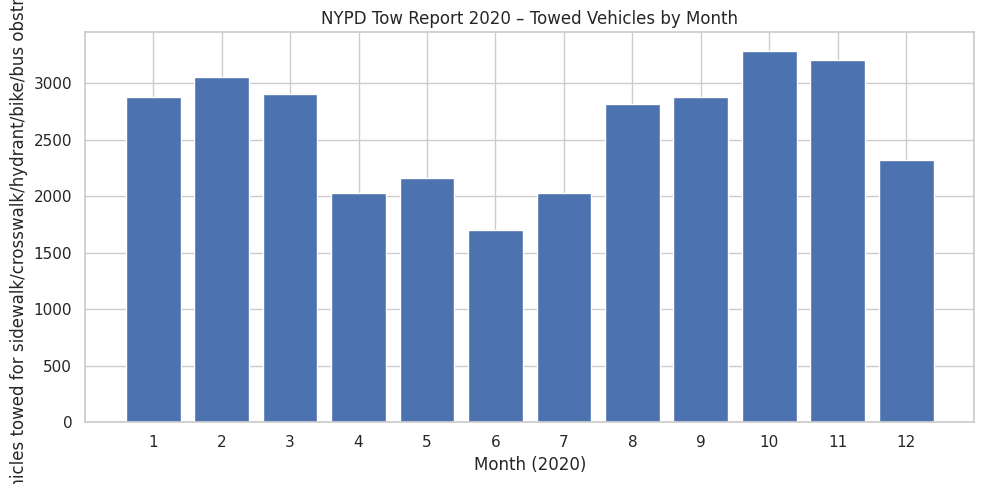

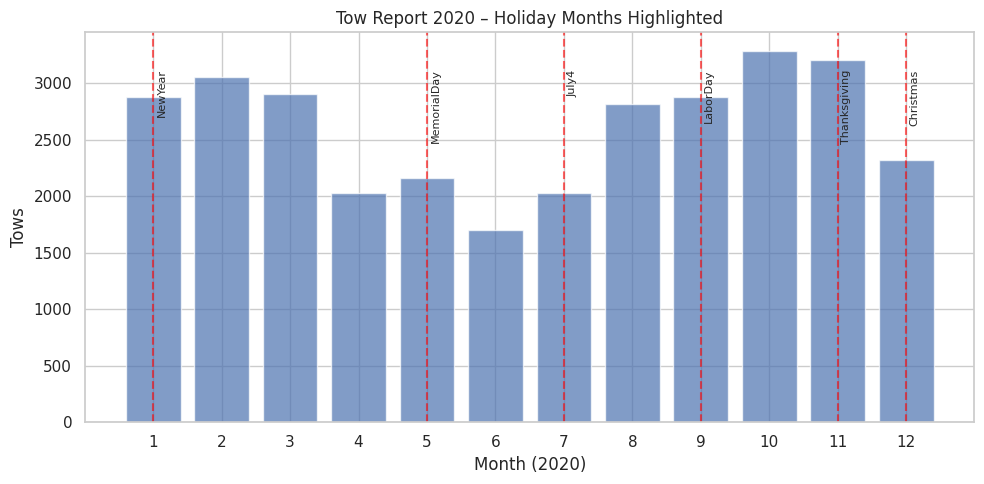

In [19]:
if "tow_agg" in locals():
    def parse_month_label(val):
        if pd.isna(val):
            return np.nan
        s = str(val).strip()
        # try integer
        try:
            m = int(s)
            if 1 <= m <= 12:
                return m
        except ValueError:
            pass
        # try full month name
        try:
            dt = pd.to_datetime(s, format="%B")
            return dt.month
        except Exception:
            pass
        # try abbreviated month name
        try:
            dt = pd.to_datetime(s, format="%b")
            return dt.month
        except Exception:
            return np.nan

    tow_agg["month_num"] = tow_agg["month_label"].apply(parse_month_label)
    tow_agg = tow_agg.dropna(subset=["month_num"])
    tow_agg["month_num"] = tow_agg["month_num"].astype(int)

    tow_agg = tow_agg.sort_values("month_num")
    display(tow_agg)

    # Basic bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(tow_agg["month_num"], tow_agg["tows"])
    plt.xticks(tow_agg["month_num"])
    plt.xlabel("Month (2020)")
    plt.ylabel("Vehicles towed for sidewalk/crosswalk/hydrant/bike/bus obstruction")
    plt.title("NYPD Tow Report 2020 – Towed Vehicles by Month")
    plt.tight_layout()
    plt.show()

    # Highlight months with major holidays
    holiday_months_2020 = {
        "NewYear": 1,
        "MemorialDay": 5,
        "July4": 7,
        "LaborDay": 9,
        "Thanksgiving": 11,
        "Christmas": 12,
    }

    plt.figure(figsize=(10, 5))
    plt.bar(tow_agg["month_num"], tow_agg["tows"], alpha=0.7, label="Towed vehicles")
    for name, m in holiday_months_2020.items():
        plt.axvline(m, color="red", linestyle="--", alpha=0.6)
        plt.text(
            m + 0.05,
            tow_agg["tows"].max() * 0.95,
            name,
            rotation=90,
            va="top",
            fontsize=8,
        )
    plt.xticks(tow_agg["month_num"])
    plt.xlabel("Month (2020)")
    plt.ylabel("Tows")
    plt.title("Tow Report 2020 – Holiday Months Highlighted")
    plt.tight_layout()
    plt.show()
else:
    print("tow_agg not defined.")


In [58]:
def quick_summary():
    print("=== Quick Summary (High-Level, Non-Causal) ===\n")
    # 1. Overall average
    overall_mean = tickets_daily["tickets"].mean()
    print(f"Average daily tickets (2019-07 to 2024-06): {overall_mean:,.0f}\n")

    # 2. Holiday window effect
    if "holiday_window_14" in df_reg.columns and "holiday_window_14" in model.params.index:
        coef = model.params["holiday_window_14"]
        conf_int = model.conf_int().loc["holiday_window_14"]
        print("Regression estimate for holiday_window_14 (±14 days around major holidays):")
        print(f"  Extra tickets per day: {coef:,.0f}")
        print(f"  95% confidence interval: [{conf_int[0]:,.0f}, {conf_int[1]:,.0f}]")
        print("  (Controls for month & weekday patterns)\n")

    # 3. Holiday-centered curves – just print rough sense
    for holiday in ["Thanksgiving", "Christmas", "July4", "NewYear"]:
        df_h = holiday_centered_curve(holiday, window=7)
        if df_h.empty:
            continue
        avg_before = df_h[df_h["offset"].between(-7, -1)]["tickets"].mean()
        avg_after = df_h[df_h["offset"].between(1, 7)]["tickets"].mean()
        print(f"{holiday}:")
        print(f"  Avg tickets 1–7 days BEFORE: {avg_before:,.0f}")
        print(f"  Avg tickets 1–7 days AFTER : {avg_after:,.0f}\n")

quick_summary()


=== Quick Summary (High-Level, Non-Causal) ===

Average daily tickets (2019-07 to 2024-06): 17,178

Regression estimate for holiday_window_14 (±14 days around major holidays):
  Extra tickets per day: 703
  95% confidence interval: [-1,059, 2,465]
  (Controls for month & weekday patterns)

Thanksgiving:
  Avg tickets 1–7 days BEFORE: 18,372
  Avg tickets 1–7 days AFTER : 18,223

Christmas:
  Avg tickets 1–7 days BEFORE: 13,278
  Avg tickets 1–7 days AFTER : 13,397

July4:
  Avg tickets 1–7 days BEFORE: 18,128
  Avg tickets 1–7 days AFTER : 20,381

NewYear:
  Avg tickets 1–7 days BEFORE: 13,720
  Avg tickets 1–7 days AFTER : 14,096



In [59]:
import pandas as pd
import numpy as np

# Your aggregated towing data
tow_agg = pd.DataFrame({
    "month_label": ["January","February","March","April","May","June","July","August",
                    "September","October","November","December"],
    "tows": [2884,3054,2902,2026,2164,1698,2032,2820,2876,3288,3204,2318],
    "month_num": [1,2,3,4,5,6,7,8,9,10,11,12]
})

# ---- Basic Statistics ----
overall_avg = tow_agg["tows"].mean()
tow_agg["pct_from_avg"] = (tow_agg["tows"] - overall_avg) / overall_avg * 100
tow_agg_sorted = tow_agg.sort_values("tows", ascending=False)

# ---- Holiday Months ----
holiday_months = {
    1: "NewYear",
    5: "MemorialDay",
    7: "July4",
    9: "LaborDay",
    11: "Thanksgiving",
    12: "Christmas"
}

tow_agg["is_holiday_month"] = tow_agg["month_num"].map(lambda m: m in holiday_months)

# Split data
holiday_df = tow_agg[tow_agg["is_holiday_month"]]
nonholiday_df = tow_agg[~tow_agg["is_holiday_month"]]

holiday_avg = holiday_df["tows"].mean()
nonholiday_avg = nonholiday_df["tows"].mean()

# ---- Print Analysis ----
print("===== NYPD Towing Analysis (2020) =====\n")

print(f"Overall average tows/month: {overall_avg:,.0f}\n")

print("Monthly tow counts ranked (highest to lowest):")
display(tow_agg_sorted)

print("\nHoliday months and tow counts:")
display(holiday_df[["month_label","tows","pct_from_avg"]])

print("\n===== Summary =====\n")

print(f"Average in HOLIDAY months: {holiday_avg:,.0f} tows/month")
print(f"Average in NON-holiday months: {nonholiday_avg:,.0f} tows/month")
print(f"Difference: {holiday_avg - nonholiday_avg:,.0f} tows/month")
print(f"Percent difference: {(holiday_avg - nonholiday_avg)/nonholiday_avg*100:.2f}%\n")

# Identify highest months
highest_month = tow_agg_sorted.iloc[0]
print(f"Highest month overall: {highest_month['month_label']} "
      f"({highest_month['tows']:,.0f} tows)")

# Identify where holiday months fall in rank
print("\nRank position of each holiday month:")
for _, row in holiday_df.iterrows():
    rank = tow_agg_sorted.index.get_loc(row.name) + 1
    print(f"- {row['month_label']:10s}: {row['tows']:4.0f} tows  → Rank {rank} of 12")

# ---- Final Interpretation ----
print("\n===== Interpretation =====\n")

# Holiday behavior:
if holiday_avg > nonholiday_avg:
    print("Holiday months have HIGHER tow volumes on average than non-holiday months.")
else:
    print("Holiday months do NOT have higher tow volumes than non-holiday months on average.")

# Inspect individual patterns:
print("\nDetailed insights:")
for _, r in holiday_df.iterrows():
    print(f"- {r['month_label']:10s}: {r['tows']:4.0f} tows "
          f"({r['pct_from_avg']:.1f}% vs yearly avg)")

print("\nAnalysis complete.")


===== NYPD Towing Analysis (2020) =====

Overall average tows/month: 2,606

Monthly tow counts ranked (highest to lowest):


,month_label,tows,month_num,pct_from_avg
9,October,3288,10,26.194588
10,November,3204,11,22.970639
1,February,3054,2,17.213587
2,March,2902,3,11.379774
0,January,2884,1,10.688927
8,September,2876,9,10.381884
7,August,2820,8,8.232585
11,December,2318,12,-11.034350
4,May,2164,5,-16.944924
6,July,2032,7,-22.011130



Holiday months and tow counts:


,month_label,tows,pct_from_avg
0,January,2884,10.688927
4,May,2164,-16.944924
6,July,2032,-22.011130
8,September,2876,10.381884
10,November,3204,22.970639
11,December,2318,-11.034350



===== Summary =====

Average in HOLIDAY months: 2,580 tows/month
Average in NON-holiday months: 2,631 tows/month
Difference: -52 tows/month
Percent difference: -1.96%

Highest month overall: October (3,288 tows)

Rank position of each holiday month:
- January   : 2884 tows  → Rank 5 of 12
- May       : 2164 tows  → Rank 9 of 12
- July      : 2032 tows  → Rank 10 of 12
- September : 2876 tows  → Rank 6 of 12
- November  : 3204 tows  → Rank 2 of 12
- December  : 2318 tows  → Rank 8 of 12

===== Interpretation =====

Holiday months do NOT have higher tow volumes than non-holiday months on average.

Detailed insights:
- January   : 2884 tows (10.7% vs yearly avg)
- May       : 2164 tows (-16.9% vs yearly avg)
- July      : 2032 tows (-22.0% vs yearly avg)
- September : 2876 tows (10.4% vs yearly avg)
- November  : 3204 tows (23.0% vs yearly avg)
- December  : 2318 tows (-11.0% vs yearly avg)

Analysis complete.


,month_num,month_name,tickets_total,tows_total,tickets_norm,tows_norm
0,1,Jan,6097063,2884.0,0.685230,0.877129
1,2,Feb,5507850,3054.0,0.619010,0.928832
2,3,Mar,6695387,2902.0,0.752473,0.882603
3,4,Apr,5839305,2026.0,0.656261,0.616180
4,5,May,6080519,2164.0,0.683370,0.658151
5,6,Jun,6559591,1698.0,0.737212,0.516423
6,7,Jul,7992267,2032.0,0.898226,0.618005
7,8,Aug,8897839,2820.0,1.000000,0.857664
8,9,Sep,7653308,2876.0,0.860131,0.874696
9,10,Oct,6978202,3288.0,0.784258,1.000000


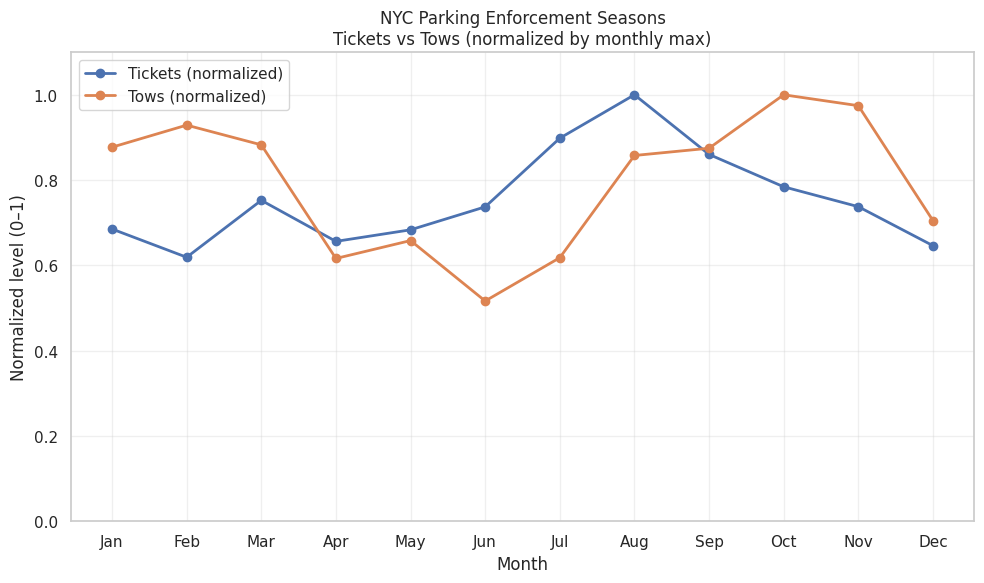

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# 1. Ensure tickets_daily has a datetime index
# =====================================================
if "date" in tickets_daily.columns:
    tickets_daily["date"] = pd.to_datetime(tickets_daily["date"])
    tickets_daily = tickets_daily.set_index("date").sort_index()

# Month number & name for tickets
tickets_daily["month_num"] = tickets_daily.index.month
tickets_daily["month_name"] = tickets_daily.index.month_name()

# Total tickets per calendar month (sum over all years)
tickets_monthly = (
    tickets_daily
    .groupby("month_num")["tickets"]
    .sum()
    .reset_index()
    .sort_values("month_num")
)

# Attach short month labels
month_order  = [1,2,3,4,5,6,7,8,9,10,11,12]
month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]
tickets_monthly["month_name"] = tickets_monthly["month_num"].map(
    dict(zip(month_order, month_labels))
)

# =====================================================
# 2. Make sure tow_agg has month_num and is sorted
#    (tow_agg should already be: month_label, tows, month_num)
# =====================================================
def parse_month_label(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    try:
        m = int(s)
        if 1 <= m <= 12:
            return m
    except ValueError:
        pass
    for fmt in ("%B", "%b"):
        try:
            return pd.to_datetime(s, format=fmt).month
        except Exception:
            continue
    return np.nan

if "month_num" not in tow_agg.columns:
    tow_agg["month_num"] = tow_agg["month_label"].apply(parse_month_label)

tow_agg = tow_agg.dropna(subset=["month_num"])
tow_agg["month_num"] = tow_agg["month_num"].astype(int)
tow_agg = tow_agg.sort_values("month_num")

# If needed, align to same 12-month ordering
tow_agg = tow_agg.set_index("month_num").reindex(month_order).reset_index()

# =====================================================
# 3. Build a combined dataframe & normalize (0–1) so they share a scale
# =====================================================
combined = pd.DataFrame({
    "month_num": month_order,
    "month_name": month_labels,
    "tickets_total": tickets_monthly.set_index("month_num").loc[month_order, "tickets"].values,
    "tows_total": tow_agg.set_index("month_num").loc[month_order, "tows"].values,
})

# Normalize each series to [0,1] to compare *seasonal shape*
combined["tickets_norm"] = combined["tickets_total"] / combined["tickets_total"].max()
combined["tows_norm"]    = combined["tows_total"]    / combined["tows_total"].max()

display(combined)

# =====================================================
# 4. Plot combined chart
# =====================================================
plt.figure(figsize=(10,6))

plt.plot(combined["month_name"], combined["tickets_norm"],
         marker="o", label="Tickets (normalized)", linewidth=2)
plt.plot(combined["month_name"], combined["tows_norm"],
         marker="o", label="Tows (normalized)", linewidth=2)

plt.title("NYC Parking Enforcement Seasons\nTickets vs Tows (normalized by monthly max)")
plt.xlabel("Month")
plt.ylabel("Normalized level (0–1)")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
